# Import libraries

In [1]:
import numpy as np
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
import random
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
pd.set_option('display.max_colwidth', None)

2024-05-16 07:42:32.645227: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-16 07:42:33.063495: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Create corpus and Preprocessing

Let's remove all punctutation marks and make everything lowercase.

In [2]:
# Define the remove_non_english function
def remove_non_english(text):
    # Regular expression to remove non-English alphabet characters
    english_only = re.sub(r'[^a-zA-Z\s.,;?!\'-]', '', text)
    return english_only

# Define the create_corpus function
def create_corpus(text):
    # Tokenize text into sentences
    sentences = text.split('\n')
    # Remove empty strings
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    # Join sentences into a corpus
    corpus = '\n'.join(sentences)  # Keep newline characters
    return corpus

# Read the CSV file
csv_path = "/home/akaagi/Desktop/SCIA/nlp1/NLP1_Project/data_raw/our_dataset.csv"
df = pd.read_csv(csv_path)

# Apply remove_non_english function to poem column
df['poem'] = df['poem'].apply(remove_non_english)

# Apply create_corpus function to poem column
df['poem'] = df['poem'].apply(create_corpus)

# Remove \xa0
df['poem'] = df['poem'].str.replace('\xa0', '')

# Apply lowercase to the poem column
df['poem'] = df['poem'].str.lower()

# Print the DataFrame
df


,Unnamed: 0,poem,topic
0,0,"sunday we lay hands\non a girl of ten hand on hand on\ncornsilk hair. we sing\nthe secret language sung\nthe day the tin roof of the tower beat\non gods floorboard\nhe got cramp in heaven.\nlike our crying and our\nfornicating so close to his bed\nwas so many shrill mice in a pretty\npine floor. to heal\nthe girl with the crippled up leg\ngod sends back the song\nhe took and down it comes\ncontrary in one mouth as fire\ngentle on our bodies as rain.\nsoft rain swells the cumberland\nand all her fields in april nuzzles\nbuttercups the mules wont touch\nthe crowpoison the wake-robin\nthe bluets of the field.\nevery song got a beat beneath.\nstart with the whippoorwill\nearly meadow colors creep\ninto the sky. my sons made this\ntobacco sled i prime with the jenny\ntoss the last of the sandlugs for the rest\nto thrive. so hot the wasps hang on the honeysuckle\ntoo spent to buzz a sermon.\ni know my song remembers\nwhat my fathers told their strings.\ndriskill, kentuckydriskill, kentucky",religion
1,1,"o transientvoyager of heaven!\no silent sign of winter skies!\nwhat adverse wind thy sail has driven\nto dungeons where a prisoner lies?\nmethinks the hands that shut the sun\nso sternly from this morning's brow\nmight still their rebel task have done\nand checked a thing so frail as thou.\nthey would have done it had they known\nthe talisman that dwelt in thee,\nfor all the suns that ever shone\nhave never been so kind to me!\nfor many a week, and many a day\nmy heart was weighed with sinking gloom\nwhen morning rose in mourning grey\nand faintly lit my prison room\nbut angel like, when i awoke,\nthy silvery form, so soft and fair\nshining through darkness, sweetly spoke\nof cloudy skies and mountains bare;\nthe dearest to a mountaineer\nwho, all life long has loved the snow\nthat crowned his native summits drear,\nbetter, than greenest plains below.\nand voiceless, soulless, messenger\nthy presence waked a thrilling tone\nthat comforts me while thou art here\nand will sustain when thou art gone",religion
2,2,"a cento for sarah hegazy\na cento for sarah hegazy\na cento for sarah hegazyin the hiding\nhour of autophagy\nghosts hang out all day and talk to us.\nan archival haunting demanding tribute\nhalf a lime for breakfast every day.\nhuman voices keening in pain\ntheir bodies, consumed by fire\nlight up the dark\n.\nthey will blame the early morning hours\nunder the seal of secrecy\nwhere there was no sunrise\nthough\nmoon tells me god is love unconditional. i\nten thousand years old and no wind\nmilk souring on my tongue\nwhisper until we sleep\ndo you see the map home?\nthis world will have you running to stone for embrace\ngravestone gentler than human.\nthe wretched left a monument of comments that day\nin the place of thunder,\ni have faith in a world of signs and wonder.\nthis time it will be different\narab spring forcing its way\nold life re-members\nlightening would manifest from the stale air.\nyou are prepared for all of it\nparaded processions wedding ecstatic\nwhen the fists rush towards your gut\nthey will find instead smoke.\nour desire up to our throats,\nincreased blood flow ripping heart open from within\ndead now after decimating perfectly healthy skin\nwe will become history contested.\na light in the earth of her chest.\ngrief is a country without borders\neulogy to be read from right to left\nbabas tongue buried in sand\ni dream in arabic of salt drink gallons\nbut the ocean stays the ocean and once again i wake\nam a wake in english.\nim thirsty is whats killing me most.\ndont die this way.\nwake up drink water one foot and then the next walk meet the sun\na face that is so itself\nto look upon it on that summer day was like drinking\nprism refracting rainbow\nrupture rapture\nwho washed her, who folded her into eternity, who\nthis is the only river i want to write about.\ni am the entire galaxy in a drop.\ndont you know i am everything?\nan absconded city of bees.\na novel adject

In [3]:
# Create an empty list to store lines of text
corpus = []

# Initialize a counter for the number of lines added to the corpus
line_count = 0

# Iterate over each poem in the DataFrame
for poem in df['poem']:
    # Split the poem into lines
    lines = poem.split('\n')
    # Iterate over each line in the poem
    for line in lines:
        # Append the line to the corpus
        corpus.append(line)
        # Increment the line count
        line_count += 1
        # Check if the corpus has reached the maximum size of 10,000 lines
        if line_count >= 10000:
            break
    # Check if the corpus has reached the maximum size of 10,000 lines
    if line_count >= 10000:
        break
    
corpus[:10]


['sunday we lay hands',
 'on a girl of ten hand on hand on',
 'cornsilk hair. we sing',
 'the secret language sung',
 'the day the tin roof of the tower beat',
 'on gods floorboard',
 'he got cramp in heaven.',
 'like our crying and our',
 'fornicating so close to his bed',
 'was so many shrill mice in a pretty']

In [4]:
len(corpus)

10000

# Tokenization

Models can't understand words, so we need to convert our words into numbers. This is what Tokenization does.

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [6]:
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 13448


# Generate n-grams

N-grams are the way we convert a poetry generation problem into a supervised learning problem.

Here is how it works.

**1. Tokenize sentence**

```
sentence = poetry generation is so much fun

tokens = [ 42, 124, 9, 12, 97, 512]
```

**2. Generate n-grams**

```
tokens = [ 42, 124, 9, 12, 97, 512]

N-grams:

    [ 42, 124 ]                   # first two words
    [ 42, 124, 9 ]                # first three words
    [ 42, 124, 9, 12 ]            # first four words
    [ 42, 124, 9, 12, 97 ]        # first five words
    [ 42, 124, 9, 12, 97, 512 ]   # first six words
```

**3. Pad n-grams**

Padding is how we make all the n-grams the same length.

```
Padded N-grams:

    [ 0, 0, 0, 0, 42, 124 ]
    [ 0, 0, 0, 42, 124, 9 ]
    [ 0, 0, 42, 124, 9, 12 ]
    [ 0, 42, 124, 9, 12, 97 ]
    [ 42, 124, 9, 12, 97, 512 ]
```

**4. Split n-grams into X and y**

Our aim is to create a model which can predict the next most probable word, given an input sequence.

Therefore we can split our n-grams in the following way: The last token is our label (Y) and the preceding tokens are the features (X).

```
Padded N-grams, split into X and y:

             X                  Y

    [ 0, 0, 0, 0, 42]        [ 124 ]
    [ 0, 0, 0, 42, 124 ]     [ 9 ]
    [ 0, 0, 42, 124, 9 ]     [ 12 ]
    [ 0, 42, 124, 9, 12 ]    [ 97 ]
    [ 42, 124, 9, 12, 97 ]   [ 512 ]

```

## Tokenize and Generate n-grams

In [7]:
n_grams = []
max_sequence_len = 0

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)
        # calculate maximum sequence length
        if len(n_gram) > max_sequence_len:
            max_sequence_len = len(n_gram)
        
print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")

Number of n-grams: 67317
Maximum n-gram length: 1646


In [8]:
for n_gram in n_grams[:10]:
    print(n_gram)

[541, 27]
[541, 27, 576]
[541, 27, 576, 207]
[16, 4]
[16, 4, 315]
[16, 4, 315, 3]
[16, 4, 315, 3, 818]
[16, 4, 315, 3, 818, 132]
[16, 4, 315, 3, 818, 132, 16]
[16, 4, 315, 3, 818, 132, 16, 132]


## Pad n-grams

In [9]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(67317, 100)

In [10]:
for seq in padded_n_grams[:3]:
    print(seq)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 541  27]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0 541  27 576]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0

## Split n-grams into X and y

In [11]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (67317, 99)
y: (67317,)


In [12]:
# one hot encode y

y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (67317, 13448)


# Modelling

Now let's create a model which can predict the next most probable word, given an input sequence.

In [13]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

2024-05-16 07:42:34.116593: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-16 07:42:34.140906: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.fit(
    X, 
    y, 
    epochs=150,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - accuracy: 0.0486 - loss: 7.9083
Epoch 2/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.0694 - loss: 7.0934
Epoch 3/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 47s 89ms/step - accuracy: 0.0800 - loss: 6.8127
Epoch 4/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.0896 - loss: 6.5929
Epoch 5/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 55s 105ms/step - accuracy: 0.0971 - loss: 6.3818
Epoch 6/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 54s 103ms/step - accuracy: 0.1068 - loss: 6.1655
Epoch 7/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.1151 - loss: 5.9695
Epoch 8/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 49s 94ms/step - accuracy: 0.1238 - loss: 5.7604
Epoch 9/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.1400 - loss: 5.5401
Epoch 10/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.1498 - loss: 5.3315
Epoch 11/150
526/526 ━━━━━━━━━━━━━━━━━━━━ 46s 88ms/step - accuracy: 0.1633 - loss: 5.1074
Epoch 12/150
526/

# Plot learning curves

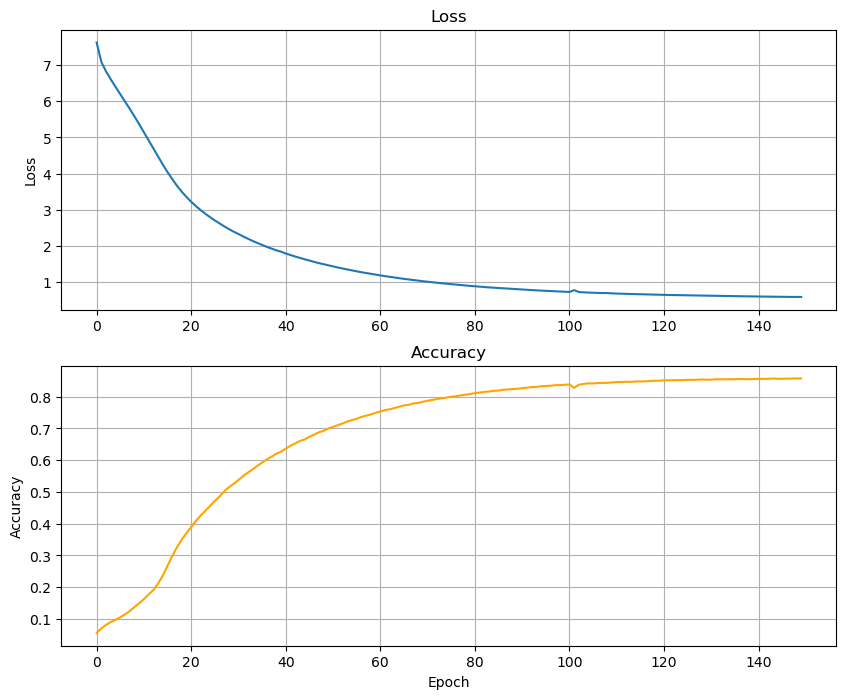

In [15]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

# Poetry generation

In [16]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
        if output_word == '\n':  # Add newline after newline token
            seed_text += '\n'
    print(seed_text)

In [17]:
generate("Hello there", 200)

Hello there to a different father though he saw the tree of glory have a son made of dirt he has were blue eyes and saw the recording angel is the time for the bottles breath the sound is the deadly another being town like that the omen has were enough shed hear us on any wye it has no holiness in the line of spring accord as a black woman from their souls these nostalgic recreations do they make the choice to you want to be part of your america though are we not america her joints brittle dragging a ripped gown through oakland i cant stand your ground im sick of calling your recklessness the law each night i count my brothers in the morning when some do not survive to be counted i count the holes they leave i reach for black folks touch only air your master magic trick america now hes breathing now he dont abra cadaver white bread voodoo sorcery you claim not to practice hand my cousin a pistol to do your work i tried white people i tried to love you but you spent my brothers funeral 

In [18]:
generate("I don't know what I would do",200)

I don't know what I would do little but how can you have is time but do you want but to fulfil about the lower place   once addicted to the end and at all the old ones see holding the line of god has were blue a god of this when and you can sit and quietly take account of your silent meeting take the quiet with you to be that can you find the time for greeting a large pot of porridge for us is the tragedy impossible to explain because this is how it manifests itself using a long saw we cut down a tree lets make a frame were shadows slipping in through the window we let the hot red bean porridge drip to the ground below those keys and the time for that moan you where we press those keys was away down talking they we are museums of fur hooves and fangs part of no eyes of a tv luminous solely from vhf and framed by the window a blue honda car of his youth these nostalgic recreations do they make you wonder if you see joe arpaio levitating each leg this life this life this steps nothing as

In [19]:
generate("It was a wonderful time", 200)

It was a wonderful time how to be a new body voided walking with his star stitched up note without any human ghost loss up ive been holding the rest of the body of the father who has the nature of the sunrise of medicine the upanishads the vedas the sutras and suras the sermon on the mount but what is  suffering is it true that it requires my consent light it has no light of it so if it quiet to you in that loud way of your america though he was a prayer at sunset beginning when the sun sets and ending after dusk there is a prayer at night beginning after dusk and ending at dawn color they will not ask you to say a one line at day i have called that well i bid you war i bid you our lives to gamble with no need the law that was his to do we did not build your boats though we did leave a trail of kin to guide us home we did not build your prisons though we did we fill them too we did not say to say that we are already inside the underworld that the apocalypse


In [20]:
generate("I made a poetry machine", 200)

I made a poetry machine are always there to be the devil speak to the south and the sea would gleam like touch the lines came from a floating spirits he left something she saw his favorite time he leave the nine tails lashing in the simple night use i looked at the night holding when they submerge each bottle yael imagines the rest is the bottles breath that comes the bright an x turning from the mountain an those drenched in the distance erasing where you say say yessayyes brightly the shore the shore that was that we tried to speak daring to be the house of the place where my face transformed he grew freckles where do you say jon say jon boy so many people feel the flowers in my back alerts the ghosts emit across the nation state wuaahh buu did you perform three miracles for a virile hag a witch with universes for eyes yourself by the might find see this morning find dying the rest you we are we fill them too we did not ask to be part of your america though are we not america her joi